In [1]:
import os.path as osp
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

import fish_models

In [2]:
import robofish.io

# Data

In [3]:
raycast = fish_models.Raycast(
            n_fish_bins=5,
            n_wall_raycasts=5,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [4]:
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"

dset = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\test"

dset_test = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\validation"

dset_val = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)

Loading data from 197 files.


100%|████████████████████████████████████████| 197/197 [00:09<00:00, 19.89it/s]


None
Calculating views from 197 files.


100%|████████████████████████████████████████| 197/197 [01:33<00:00,  2.10it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 24580.63it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 19604.20it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 197/197 [00:00<00:00, 9778.78it/s]


Status of IoDataset:
poses	(197, 8, 749, 3):	consisting of x, y, orientation.
actions	(197, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(197, 8, 749, 15):	consisting of 5 fish bins, 5 fish oris and 5 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
Loading data from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:01<00:00, 15.51it/s]


None
Calculating views from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:13<00:00,  1.72it/s]


Reducing shape of poses.


100%|██████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]


Reducing shape of actions.


100%|██████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]


Reducing shape of views.


100%|████████████████████████████████████████| 24/24 [00:00<00:00, 2981.64it/s]


Status of IoDataset:
poses	(24, 8, 749, 3):	consisting of x, y, orientation.
actions	(24, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(24, 8, 749, 15):	consisting of 5 fish bins, 5 fish oris and 5 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
Loading data from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:01<00:00, 17.92it/s]


None
Calculating views from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:11<00:00,  2.02it/s]


Reducing shape of poses.


100%|██████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]


Reducing shape of actions.


100%|██████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]


Reducing shape of views.


100%|████████████████████████████████████████| 24/24 [00:00<00:00, 1987.94it/s]

Status of IoDataset:
poses	(24, 8, 749, 3):	consisting of x, y, orientation.
actions	(24, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(24, 8, 749, 15):	consisting of 5 fish bins, 5 fish oris and 5 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them


In [6]:
more_than_2_mask = (~np.isnan(dset["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 4
more_than_2_mask_test = (~np.isnan(dset_test["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 4
more_than_2_mask_val = (~np.isnan(dset_val["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 4
more_than_2_mask.shape, more_than_2_mask.sum(), more_than_2_mask_test.shape, more_than_2_mask_test.sum(), more_than_2_mask_val.shape, more_than_2_mask_val.sum()

((197,), 27, (24,), 1, (24,), 2)

In [7]:
swarm_poses = dset["poses"][more_than_2_mask]
swarm_actions = dset["actions"][more_than_2_mask]
swarm_views = dset["views"][more_than_2_mask]
swarm_poses.shape, swarm_actions.shape, swarm_views.shape

((27, 8, 749, 3), (27, 8, 749, 2), (27, 8, 749, 15))

In [8]:
arrrr = np.round(swarm_actions[:,:,:,0].flatten()[~np.isnan(swarm_actions[:,:,:,0].flatten())])
arrrr.min(), arrrr.mean(), arrrr.max()

(8.0, 8.0, 8.0)

## Single Track Dataset

In [9]:
small_poses = swarm_poses[:1]
small_actions = swarm_actions[:1]
small_views = swarm_views[:1]
small_poses.shape, small_actions.shape, small_views.shape

((1, 8, 749, 3), (1, 8, 749, 2), (1, 8, 749, 15))

In [10]:
data_list = []
for graph_time, graph_action in zip(small_poses, small_actions):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

train_dataset = data_list
train_small_loader = DataLoader(train_dataset, batch_size=128)

## Action Prediction Dataset

In [11]:
data_list = []
for graph_time, graph_action in zip(swarm_poses, swarm_actions):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

train2_loader = DataLoader(data_list, batch_size=256)

In [12]:
swarm_poses_test = dset_test["poses"][more_than_2_mask_test]
swarm_actions_test = dset_test["actions"][more_than_2_mask_test]
swarm_views_test = dset_test["views"][more_than_2_mask_test]
swarm_poses_test.shape, swarm_actions_test.shape, swarm_views_test.shape

((1, 8, 749, 3), (1, 8, 749, 2), (1, 8, 749, 15))

In [13]:
data_list = []
for graph_time, graph_action in zip(swarm_poses_test, swarm_actions_test):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

test2_loader = DataLoader(data_list, batch_size=256)

In [14]:
swarm_poses_val = dset_val["poses"][more_than_2_mask_val]
swarm_actions_val = dset_val["actions"][more_than_2_mask_val]
swarm_views_val = dset_val["views"][more_than_2_mask_val]
swarm_poses_val.shape, swarm_actions_val.shape, swarm_views_val.shape

((2, 8, 749, 3), (2, 8, 749, 2), (2, 8, 749, 15))

In [15]:
data_list = []
for graph_time, graph_action in zip(swarm_poses_val, swarm_actions_val):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

val2_loader = DataLoader(data_list, batch_size=256)

# Model

In [16]:
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv

In [17]:
class EncodingSwarmNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        torch.manual_seed(42)
#         self.encoder1 = nn.Linear(in_channels, hidden_channels//8)
#         self.encoder2 = nn.Linear(hidden_channels//8, hidden_channels)
        self.gconv1 = GraphConv(in_channels, hidden_channels)
        self.linear1 = nn.Linear(hidden_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, hidden_channels)
        self.linear3 = nn.Linear(hidden_channels, hidden_channels)
        self.predictor = nn.Linear(hidden_channels, out_channels)
        self.lrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0)

    def forward(self, x, edge_index):
#         x = self.dropout(self.lrelu(self.encoder1(x)))
#         x = self.dropout(self.lrelu(self.encoder2(x)))
        x = self.lrelu(self.gconv1(x, edge_index))
        x = self.dropout(self.lrelu(self.linear1(x)))
        x = self.dropout(self.lrelu(self.linear2(x)))
        x = self.dropout(self.lrelu(self.linear3(x)))
        x = self.predictor(x)
        return x

# Overfit to one batch

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncodingSwarmNet(3, 640, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [19]:
data = next(iter(train_small_loader))
data = data.to(device)
true_lbl = data.y.reshape((-1,1))
losses = []
for i in range(1000):
    optimizer.zero_grad()
    pred_lbl = model(data.x, data.edge_index)
    loss = criterion(pred_lbl, true_lbl)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'Epoch: {i:03d}, Train: {loss.item():.4f}, {pred_lbl.min().item():.4f}, {pred_lbl.max().item():.4f}', end="\r") 

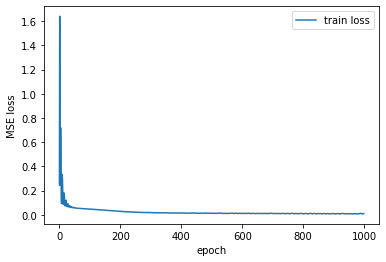

In [20]:
plt.plot(losses, label="train loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

In [21]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, regressor):
        #self.raycast = raycast
        self.regressor = regressor
        self.chosen_actions = [[], [], [], []]

    def choose_action(self, poses_3d, self_id):
        speed = 8
        num_nodes = poses_3d.shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        x_input = torch.tensor(poses_3d, dtype=torch.float)
        turn = self.regressor(x_input, edge_index).detach().numpy()[self_id].item()
        self.chosen_actions[self_id].append(turn)
        return speed, turn

In [26]:
data.x.shape

torch.Size([512, 3])

100%|███████████████████████████████████████| 128/128 [00:01<00:00, 120.09it/s]


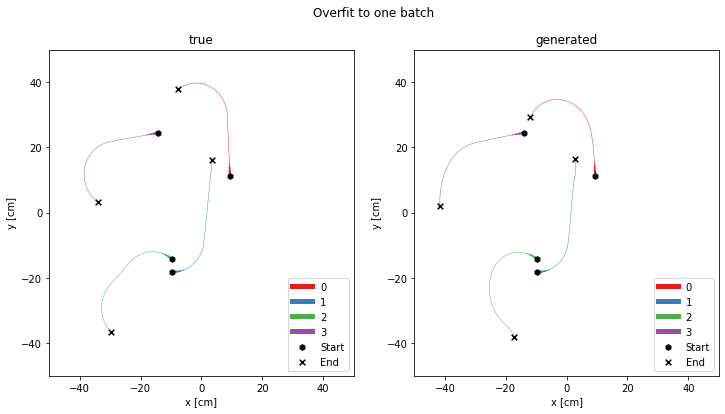

In [27]:
model.eval()
model.to("cpu")
data = data.to("cpu")
raymodel = CouzinModel(model)
generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=25)
n=2
fig, axs = plt.subplots(1,2, figsize=(12,6))
f = generator.as_io_file(np.swapaxes(data.x.reshape((data.x.shape[0]//4,4,3)).numpy(),0,1))
f.plot(lw_distances=True, ax=axs[0])
axs[0].set_title("true")
track = generator.create_track(n_guppies=4, trackset_len=data.x.shape[0]//4,
                               initial_poses=data.x.reshape((data.x.shape[0]//4,4,3))[0])
f = generator.as_io_file(track)
f.plot(lw_distances=True, ax=axs[1])
axs[1].set_title("generated")
plt.suptitle("Overfit to one batch")
plt.show()

In [29]:
data.y.reshape((data.y.shape[0]//4,4)).shape

torch.Size([128, 4])

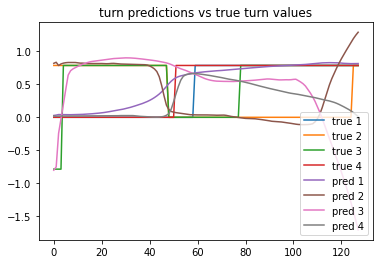

In [31]:
plt.plot(data.y.reshape((data.y.shape[0]//4,4))[:,0], label="true 1")
plt.plot(data.y.reshape((data.y.shape[0]//4,4))[:,1], label="true 2")
plt.plot(data.y.reshape((data.y.shape[0]//4,4))[:,2], label="true 3")
plt.plot(data.y.reshape((data.y.shape[0]//4,4))[:,3], label="true 4")
plt.plot(np.array(raymodel.chosen_actions)[0], label="pred 1")
plt.plot(np.array(raymodel.chosen_actions)[1], label="pred 2")
plt.plot(np.array(raymodel.chosen_actions)[2], label="pred 3")
plt.plot(np.array(raymodel.chosen_actions)[3], label="pred 4")
plt.title("turn predictions vs true turn values")
plt.legend()
plt.show()

# Overfit to one track

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncodingSwarmNet(3, 640, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.L1Loss()

In [45]:
losses = []
for i in range(5000):
    running_loss = 0
    for data in train_small_loader:
        data = data.to(device)
        true_lbl = data.y.reshape((-1,1))
        optimizer.zero_grad()
        pred_lbl = model(data.x, data.edge_index)
        loss = criterion(pred_lbl, true_lbl)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss / len(train2_loader))
    if i % 10 == 0:
        print(f'Epoch: {i:03d}, Train: {losses[-1]}', end="\r")

In [49]:
true_lbl[:5], pred_lbl[:5]

(tensor([[-0.7854],
         [ 0.7854],
         [-0.2614],
         [-0.2417],
         [-0.7854]], device='cuda:0'),
 tensor([[0.6831],
         [0.7884],
         [0.5983],
         [0.1116],
         [0.7054]], device='cuda:0', grad_fn=<SliceBackward0>))

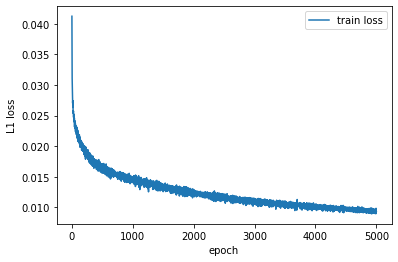

In [47]:
plt.plot(losses, label="train loss")
plt.xlabel("epoch")
plt.ylabel("L1 loss")
plt.legend()
plt.show()

In [50]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, regressor):
        #self.raycast = raycast
        self.regressor = regressor
        self.chosen_actions = [[], [], [], []]

    def choose_action(self, poses_3d, self_id):
        speed = 8
        num_nodes = poses_3d.shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        x_input = torch.tensor(poses_3d, dtype=torch.float)
        turn = self.regressor(x_input, edge_index).detach().numpy()[self_id].item()
        self.chosen_actions[self_id].append(turn)
        return speed, turn

100%|███████████████████████████████████████| 749/749 [00:03<00:00, 230.58it/s]


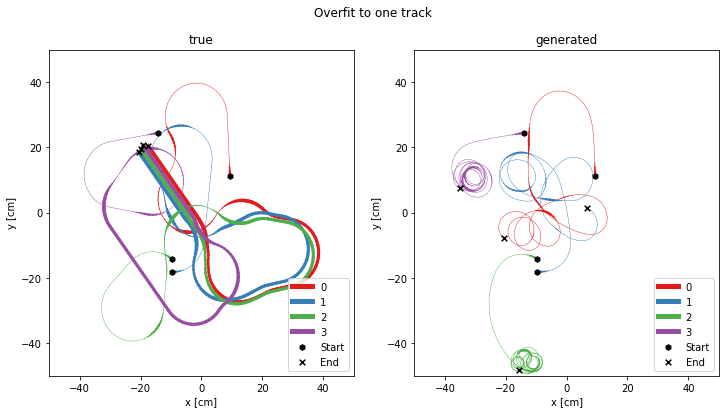

In [51]:
model.eval()
model.to("cpu")
data = data.to("cpu")
raymodel = CouzinModel(model)
generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=25)
n=2
fig, axs = plt.subplots(1,2, figsize=(12,6))
dat = np.concatenate([data.x.reshape((data.x.shape[0]//4,4,3)).numpy() for data in train_small_loader])
f = generator.as_io_file(np.swapaxes(dat,0,1))
f.plot(lw_distances=True, ax=axs[0])
axs[0].set_title("true")
track = generator.create_track(n_guppies=4, trackset_len=dat.shape[0],
                               initial_poses=dat[0])
f = generator.as_io_file(track)
f.plot(lw_distances=True, ax=axs[1])
axs[1].set_title("generated")
plt.suptitle("Overfit to one track")
plt.show()

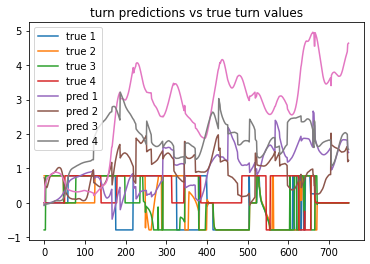

In [53]:
plt.plot(swarm_actions[0,0,:,1], label="true 1")
plt.plot(swarm_actions[0,1,:,1], label="true 2")
plt.plot(swarm_actions[0,2,:,1], label="true 3")
plt.plot(swarm_actions[0,3,:,1], label="true 4")
plt.plot(np.array(raymodel.chosen_actions)[0], label="pred 1")
plt.plot(np.array(raymodel.chosen_actions)[1], label="pred 2")
plt.plot(np.array(raymodel.chosen_actions)[2], label="pred 3")
plt.plot(np.array(raymodel.chosen_actions)[3], label="pred 4")
plt.title("turn predictions vs true turn values")
plt.legend()
plt.show()

# Training with turn label

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncodingSwarmNet(3, 640, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

losses = []
val_losses = []
for epoch in range(1000):
    model.train()
    running_loss = 0
    for data in train2_loader:
        data = data.to(device)
        true_lbl = data.y.reshape((-1,1))
        optimizer.zero_grad()
        pred_lbl = model(data.x, data.edge_index)
        loss = criterion(pred_lbl, true_lbl)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss / len(train2_loader))
    model.eval()
    running_loss2 = 0
    for data in val2_loader:
        data = data.to(device)
        true_lbl = data.y.reshape((-1,1))
        pred_lbl = model(data.x, data.edge_index)
        loss = criterion(pred_lbl, true_lbl)
        running_loss2 += loss.item()
    val_losses.append(running_loss2 / len(val2_loader))
    print(f'Epoch: {epoch:03d}, Train: {losses[-1]:.6f}, Val: {val_losses[-1]:.6f}    ', end="\r")

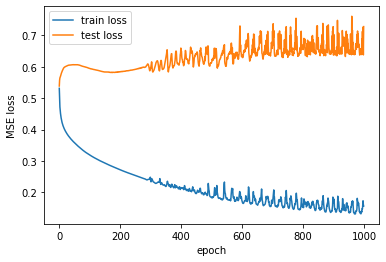

In [55]:
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="test loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

## Save Checkpoint

In [56]:
PATH = "turn_label_4fish_model.pt"

In [58]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': losses[-1],
            'val_loss': val_losses[-1],
            }, PATH)

## Load Checkpoint

In [ ]:
model = EncodingSwarmNet(3, 640, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
prev_train_loss = checkpoint['train_loss']
prev_val_loss = checkpoint['val_loss']

model.eval()

# Build Fish Model from Torch Model

In [64]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, regressor):
        #self.raycast = raycast
        self.regressor = regressor
        self.chosen_actions = [[], [], [], []]

    def choose_action(self, poses_3d, self_id):
        speed = 8
        num_nodes = poses_3d.shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        x_input = torch.tensor(poses_3d, dtype=torch.float)
        turn = self.regressor(x_input, edge_index).detach().numpy()[self_id].item()
        self.chosen_actions[self_id].append(turn)
        return speed, turn

In [67]:
model.eval()
model.to("cpu")
raymodel = CouzinModel(model)
generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=25)

100%|███████████████████████████████████████| 749/749 [00:03<00:00, 234.98it/s]


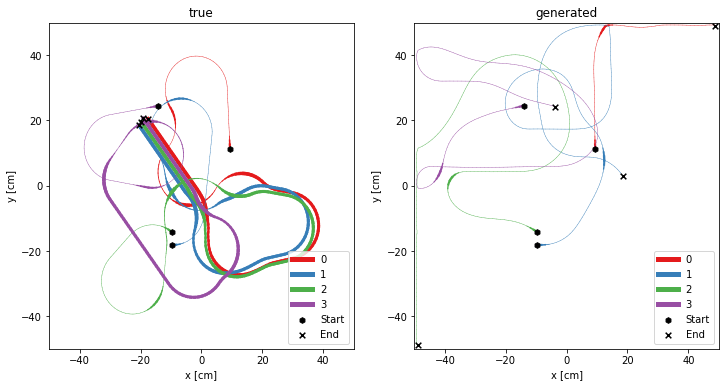

In [68]:
n=4
fig, axs = plt.subplots(1,2, figsize=(12,6))
f = generator.as_io_file(swarm_poses[0,:n,:,:])
f.plot(lw_distances=True, ax=axs[0])
axs[0].set_title("true")
track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2], initial_poses=swarm_poses[0,:n,0,:])
f = generator.as_io_file(track)
f.plot(lw_distances=True, ax=axs[1])
axs[1].set_title("generated")
plt.show()

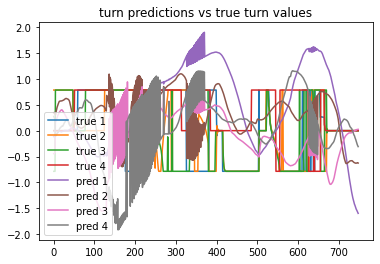

In [69]:
plt.plot(swarm_actions[0,0,:,1], label="true 1")
plt.plot(swarm_actions[0,1,:,1], label="true 2")
plt.plot(swarm_actions[0,2,:,1], label="true 3")
plt.plot(swarm_actions[0,3,:,1], label="true 4")
plt.plot(np.array(raymodel.chosen_actions)[0], label="pred 1")
plt.plot(np.array(raymodel.chosen_actions)[1], label="pred 2")
plt.plot(np.array(raymodel.chosen_actions)[2], label="pred 3")
plt.plot(np.array(raymodel.chosen_actions)[3], label="pred 4")
plt.title("turn predictions vs true turn values")
plt.legend()
plt.show()

100%|███████████████████████████████████████| 749/749 [00:03<00:00, 223.70it/s]


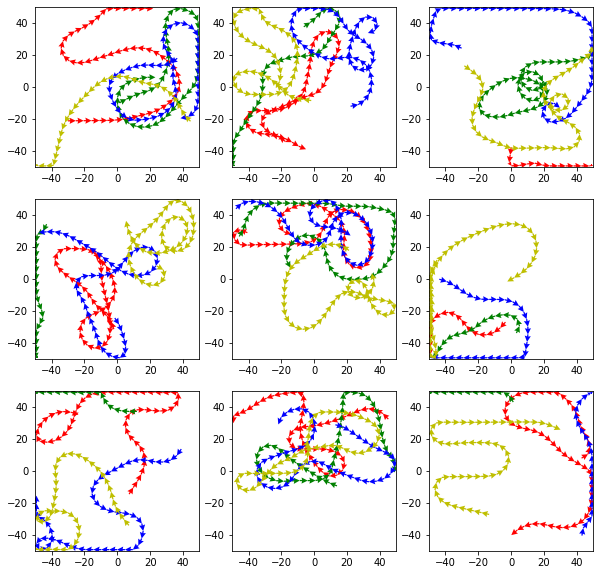

In [70]:
with torch.no_grad():
    model.eval()
    model.to("cpu")
    raymodel = CouzinModel(model)
    generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=25)
colour_list = ["r", "g", "b", "y", "black"]
n = 4
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2], )
        for fish_id in range(n):
            a = track[fish_id, ::15, 0]
            b = track[fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', 
                            scale=1, headwidth=5, color = colour_list[fish_id])
            #axs[i,j].plot(track[fish_id, :, 0], track[fish_id, :, 1], label=fish_id)
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
plt.show()

100%|███████████████████████████████████████| 749/749 [00:03<00:00, 228.66it/s]


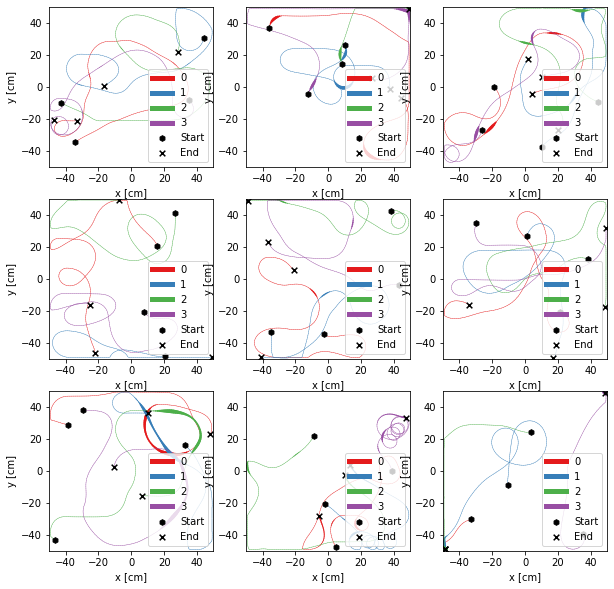

In [71]:
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
        f = generator.as_io_file(track)
        f.plot(lw_distances=True, ax=axs[i,j])
plt.show()

# Overarching Evaluation

In [63]:
n=4
paths = []
labels = []
model_path = r"D:\ResearchInternshipData\turn_label_4fish_model"
model_label = "Model Data"
for i in range(50):
    track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
    filename = r"D:\ResearchInternshipData\turn_label_4fish_model\track_" + str(i+1) + ".hdf5"
    f = generator.as_io_file(track, filename)
    paths.append(filename)
    labels.append("track_" + str(i+1))
f.close() 

100%|███████████████████████████████████████| 749/749 [00:03<00:00, 242.62it/s]


In [98]:
# model_path = r"D:\ResearchInternshipData\turn_label_4fish_model"
# model_label = "Model Data"

In [72]:
import robofish.evaluate.evaluate as robo_eval

In [73]:
f1 = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"

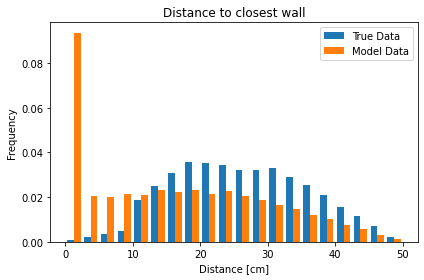

In [74]:
robo_eval.evaluate_distanceToWall([f1, model_path], ["True Data", model_label])
plt.show()

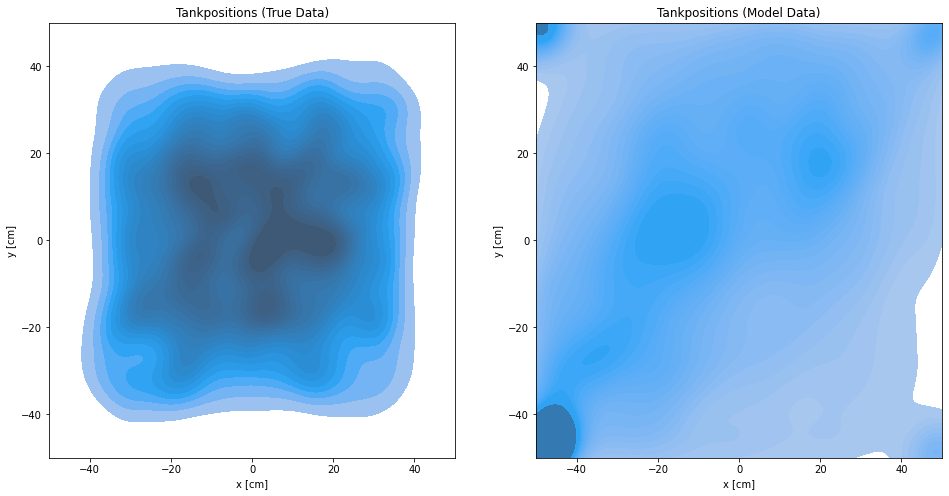

In [75]:
robo_eval.evaluate_tankpositions([f1,model_path], ["True Data",model_label])
plt.show()

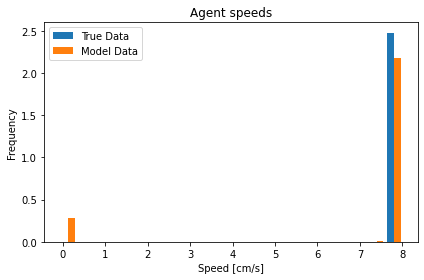

In [76]:
robo_eval.evaluate_speed([f1, model_path], ["True Data", model_label])
plt.show()

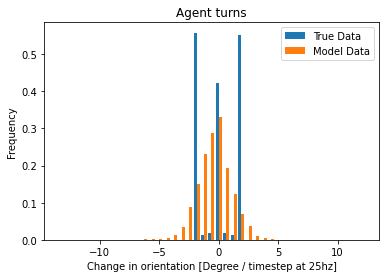

In [77]:
robo_eval.evaluate_turn([f1,model_path], ["True Data",model_label])
plt.show()

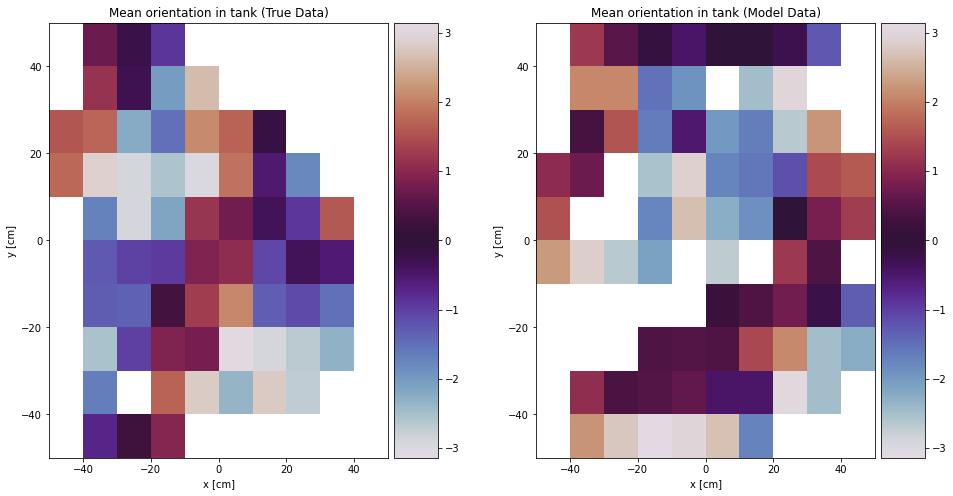

In [78]:
robo_eval.evaluate_orientation([f1, model_path], ["True Data", model_label])
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
robo_eval.evaluate_follow_iid([f1, model_path], ["True Data", model_label])
plt.tight_layout()
plt.show()